In [2]:
from z3 import *

# I. Задача

По тропинке вдоль кустов
Шли 11 хвостов.
Сосчитать я также смог,
Что шагало 30 ног.
Это вместе шли куда-то
Петухи и поросята.
А теперь вопрос таков:
Сколько было петухов?
И узнать я был бы рад,
Сколько было поросят?


Формализуем условие в терминах ограничений.

Пусть `x` будет количество петухов, `y` - количество поросят.
Тогда количество ног должно быть `x * 2 + y * 4 = 30`, а количество хвостов `x + y = 11`.
Надо найти `x` и `y`, удовлетворяющие этой системе уравнений.

`x` и `y` должны быть целыми, т.е. Int() и больше нуля. Т.е. можно вести еще условия `x >=0` и `y >= 0`.

In [8]:
x, y = Ints('x y')
solve(x >= 0, y >= 0, x * 2 + y * 4 == 30, x + y == 11)

[y = 4, x = 7]


# II. Оригинальные задачи

### 1 Tango
Дано поле

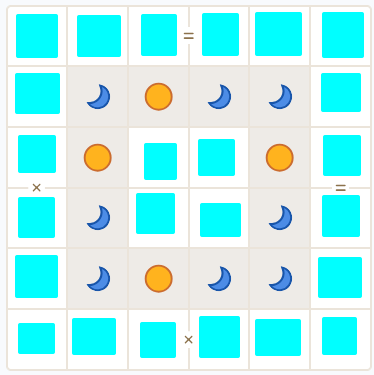

Правила:
- заполнить остальные ячейки таким образом, чтоб каждая ячейка собдержала или sun, или moon;
- не более двух солнц или moonев подряд на соседних ячейках по горизонтали или вертикали;
- каждый ряд и колонка должны содержать одинаковое количество солнц и moonев (по три в данном случае);
- ячейки разделенные крестиком `x` должны содержать разные символы;
- ячейки, разделенные символом равенства `=` должны содержать одинаковые символы.

Должна получиться такая картинка

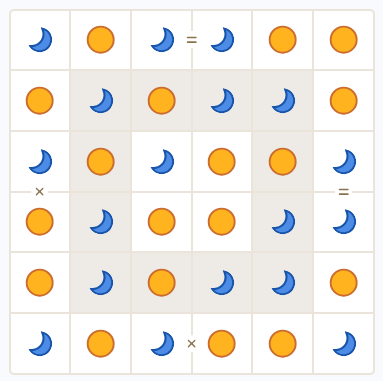

Для решения этой задачи создадим матрицу 6х6 переменных, некоторым переменным присвоим значения и задаим условия на равенство и неравенство в некоторых ячейках. Переменные будут со значениями "sun" и "moon"

In [ ]:

# исходная матрица 6Х6
X = [ [ String("x_%s_%s" % (i+1, j+1)) for j in range(6) ]
      for i in range(6) ]

# в каждой ячейке значение или "sun", или "moon"
cells_constraints  = [ Or(X[i][j] == "sun", X[i][j] == "moon")
      for i in range(6) for j in range(6) ]

# нам нужна функция-хелпер для подсчета количества солнц и месяцев
def count_equal(lst, val):
    return Sum([If(lst[i] == val, 1, 0) for i in range(len(lst))])

# ограничения для строк и столбцов
rows_constraints = [ And(count_equal(X[i], "sun") == 3, 
            count_equal(X[i], "moon") == 3)
      for i in range(6) ]

cols_constraints = [ And(
    count_equal([X[i][j] for i in range(6)], "sun") == 3,
    count_equal([X[i][j]
                 for i in range(6)], "moon") == 3)
                 for j in range(6) ]

# ограничения на недопустимость трех последовательных одинаковых значений (1 или 2 можно)
consecutive_rows = [ And(Not(And(X[i][j] == X[i][j+1], X[i][j+1] == X[i][j+2]))
                         for j in range(4))
                         for i in range(6) ]

consecutive_cols = [ And(Not(And(X[i][j] == X[i+1][j], X[i+1][j] == X[i+2][j]))
                         for i in range(4))
                         for j in range(6) ]

# задаем условия равенства и неравенства отдельных ячеек
equals_cells_constraints = [ And(X[0][2] == X[0][3], X[5][2] != X[5][3], X[2][0] != X[3][0], X[2][5] == X[3][5])]

# все ограничения собираем в один список
constraints = cells_constraints + rows_constraints + cols_constraints + consecutive_rows + consecutive_cols + equals_cells_constraints

# задаем некоторые значения
instance = (("0","0","0","0","0","0"),
            ("0","moon","sun","moon","moon","0"),
            ("0","sun","0","0","sun","0"),
            ("0","moon","0","0","moon","0"),
            ("0","moon","sun","moon","moon","0"),
            ("0","0","0","0","0","0"))

instance_constraint = [ If(instance[i][j] == "0", True, X[i][j] == instance[i][j])
                       for i in range(6) for j in range(6) ]

# собираем солвер
s = Solver()
s.add(constraints + instance_constraint)

if s.check() == sat:
    m = s.model()
    for i in range(6):
        for j in range(6):
            print(m.evaluate(X[i][j]), end=" ")
        print()
else:
    print("No solution found")


"moon" "sun" "moon" "moon" "sun" "sun" 
"sun" "moon" "sun" "moon" "moon" "sun" 
"moon" "sun" "moon" "sun" "sun" "moon" 
"sun" "moon" "sun" "sun" "moon" "moon" 
"sun" "moon" "sun" "moon" "moon" "sun" 
"moon" "sun" "moon" "sun" "sun" "moon" 


## 2 Самый дешевый путь

Пусть дана матрица 5Х5:

1 1 1 1 1<br>
3 9 9 9 9<br>
1 1 1 1 1<br>
2 2 2 2 1<br>
1 1 1 1 1<br>

где каждая цифра - штраф за прохождение по клетке. Необходимо найти самый дешевый путь, двигаясь из левого верхнего угла в правый нижний по горизонталями и вертикалям.

Должно получиться число 11.

In [3]:
# задаем начальные значения в матрице
instance = ((1,1,1,1,1),
            (3,9,9,9,9),
            (1,1,1,1,1),
            (2,2,2,2,1),
            (1,1,1,1,1))

# нужна будет вспомогательная переменная
size = 5

# переменная для стоимости
total_cost = Int("total_cost")

# введем матрицу, показывающую путь: True для ячейки, по которой мы идем, False для остальных
path = [ [ Bool("path_%d_%d" % (i, j)) for j in range(size) ]
         for i in range(size) ]

# ограничения связности пути - ячейка пути True должна иметь хотя бы одного (для концевых случаев) соседа с True
constraints = []
constraints.append(path[0][0] == True)  # начало
start_neighbors = [path[0][1], path[1][0]]
constraints.append(Implies(path[0][0], Or(start_neighbors)))

constraints.append(path[4][4] == True)  # конец
finish_neighbors = [path[4][3], path[3][4]]
constraints.append(Implies(path[4][4], Or(finish_neighbors)))

# нам нужна функция-хелпер для подсчета количества соседей True. Для любой ячейки кроме крайних их должно быть не менее двух
def count_neighbors(nbr):
    return Sum([If(nbr[i], 1, 0) for i in range(len(nbr))])

for i in range(size):
    for j in range(size):
        if (i, j) != (0, 0) and (i, j) != (4, 4):
            neighbors = []
            if i > 0:
                neighbors.append(path[i-1][j])
            if i < size - 1:
                neighbors.append(path[i+1][j])
            if j > 0:
                neighbors.append(path[i][j-1])
            if j < size - 1:
                neighbors.append(path[i][j+1])
            
            if neighbors:
                # если ячейка True -> один из соседей должен быть True
                constraints.append(Implies(path[i][j], count_neighbors(neighbors) >= 2))

# вычисление стоимости и ограничение - total_cost равен сумме ячеек, по которым пролег путь
cost_sum = Sum([If(path[i][j], instance[i][j], 0) 
                for i in range(size) for j in range(size)])
constraints.append(total_cost == cost_sum)

# я пробовал через Solver, но не нашел решение для явного поиска инимального значения. ИИ подсказал использовать Optimize вместо Solver
opt = Optimize()
opt.add(constraints)

# задаём цель оптимизации - мнимальный total_cost
opt.minimize(total_cost)

if opt.check() == sat:
    m = opt.model()
    cost = m.evaluate(total_cost).as_long()
    print(f"Минимальная стоимость пути: {cost}")
    
    print("\nПуть:")
    for i in range(size):
        for j in range(size):
            if m.evaluate(path[i][j]):
                print("X", end=" ")
            else:
                print(".", end=" ")
        print()
else:
    print("Решение не найдено")

Минимальная стоимость пути: 11

Путь:
X . . . . 
X . . . . 
X X X X X 
. . . . X 
. . . . X 


## 3 Школьная задача

Миша и Соня добирались из деревни в город - частью пешком, частью на телеге, которая едет втрое быстрее пеших ребят. Миша ровно полпути прошел пешком, а Соня проехала на телеге половину того времени, что затратил Миша на дорогу. Какую часть пути Соня проехала на телеге?

Система уравнений получается следующая:
S - расстояние от деревни до города
V - скорость Сони / Миши пешком
VT - скорость телеги
TM - время Миши
TS - время Сони на телеге
SS - расстояние Сони на телеге (искомое)

свяжем эти переменные
TM = S / 2 / V + S / 2 / VT
TS = TM / 2
SS = VT * TS
VT = 3 * V

In [9]:
s, v, vt, tm, ts, ss = Reals('s v vt tm ts ss')

equations = [
    tm == s / 2 / v + s / 2 / vt,
    ts == tm / 2,
    ss == vt * ts,
    vt == 3 * v,
]

problem = [s > 0, v > 0, vt > 0, tm > 0, ts >0, ss > 0]

solve(equations + problem)

[v = 1,
 ss = 3,
 tm = 2,
 s = 3,
 vt = 3,
 ts = 1,
 /0 = [(3/2, 3) -> 1/2, (3/2, 1) -> 3/2, else -> 0]]


# III Задачи с ChatGPT

1. Задача про мотоциклиста.<br>
Ответ Чата:<br>
Мотоциклист проедет 56,25 метра до полной остановки.<br>
Это соответствует решению с помощью солвера.<br>
<br>
2. Задача про второго мотоциклиста.<br>
Ответ Чата:<br>
За 4,1 секунды мотоцикл проедет 50,43 метра.<br>
Это соответствует решению с помощью солвера.<br>
<br>
3. Задача кот, пес и мышь.<br>
Ответ Чата:<br>
Обозначим:<br>
d — число собак (15 долларов),<br>
c — число котов (1 доллар),<br>
m — число мышей (0,25 доллара).<br>
<br>
Условия задачи<br>
Общее количество животных:<br>
<br>
d+c+m=100<br>
<br>
Общая стоимость:<br>
<br>
15d+1⋅c+0,25m=100<br>
<br>
Все величины — целые положительные:<br>
<br>
d≥1,c≥1,m≥1<br>
Приведём уравнения к удобному виду<br>
<br>
Умножим второе уравнение на 4, чтобы избавиться от дробей:<br>
<br>
60d+4c+m=400<br>
<br>
Вычтем из него первое уравнение:<br>
<br>
(60d+4c+m)−(d+c+m)=400−100<br>
59d+3c=300<br>
Поиск целочисленного решения<br>
<br>
Из уравнения:<br>
<br>
3c=300−59d<br>
<br>
Правая часть должна делиться на 3. Перебор допустимых d<br>
d=3:<br>
300−177=123, делится на 3<br>
c=41<br>
<br>
Тогда:<br>
<br>
m=100−d−c=100−3−41=56<br>
Проверка стоимости<br>
<br>
Собаки: <br>
3×15=45<br>
<br>
Коты: <br>
41×1=41<br>
<br>
Мыши: <br>
56×0,25=14<br>
<br>
45+41+14=100<br>
Решение<br>
<br>
3 собаки, 41 кот и 56 мышей.<br>
<br>
Как итог отмечу, что рассуждения ЧатГПТ напоминают ход решения в солвере.<br>
<br>
4. Судоку. ЧатГПТ ощутимо много времени потратил на ее решение и в первом ответе не выдал решение, только ответ. Решение он предлагает через таблицу кандидатов и исключения кандидатов на основе строки, столбца и квадрата.